# 1 -  Importando bibliotecas e recursos

In [ ]:
!pip install Unidecode nltk transformers datasets tensorflow-addons

In [ ]:
from enum import IntEnum, Enum
import os
import gc
import re
import string

from datasets import Dataset
import nltk
from nltk import tokenize, ngrams
import numpy as np
import pandas as pd

from pandas.io.formats.style_render import DataFrame
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, ConfusionMatrixDisplay

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
import tensorflow as tf
import tensorflow_addons as tfa

import unidecode

In [ ]:
try:
  ! git clone https://github.com/americanas-tech/b2w-reviews01.git
except:
  print('dataset already downloaded')
if not os.path.isfile('./B2W-Reviews01.parquet'):
  df = pd.read_csv('./b2w-reviews01/B2W-Reviews01.csv')
  df['product_id'] = df['product_id'].astype(str)
  df.to_parquet('./B2W-Reviews01.parquet')

df = pd.read_parquet('./B2W-Reviews01.parquet')
df = df[['review_text', 'review_title']]

df.head(2)

fatal: destination path 'b2w-reviews01' already exists and is not an empty directory.


,review_text,review_title
0,Estou contente com a compra entrega rápida o ú...,Bom
1,"Por apenas R$1994.20,eu consegui comprar esse ...","Preço imbatível, ótima qualidade"


# 2 -  Limpeza e tratamento

In [ ]:
df.describe(include=[object])

,review_text,review_title
count,129098,132071
unique,126724,56555
top,Entrega super rápida . Parabéns pela agilida...,Muito bom
freq,57,3018


In [ ]:
df = df.dropna(subset=['review_text', 'review_title'])
df = df.reset_index(drop=True)
df.dropna(inplace=True)
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df = df[["review_title", "review_text"]].apply(" ".join, axis=1)
df = pd.DataFrame(data=df,columns=['review_text'])

# 3 - Tratamento do texto

In [ ]:
nltk.download('stopwords')
nltk.download('rslp')

stopwords = nltk.corpus.stopwords.words("portuguese")
stemmer = nltk.RSLPStemmer()
translator = str.maketrans('', '', string.punctuation)

def remove_stopwords(words):
    """Remover as Stopwords das palavras tokenizadas"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """converter todos os caracteres para lowercase"""
    new_words = []
    for word in words:
        new_word = word.replace(r"^a-zA-Z0-9 ]", "")
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """remover pontuação"""
    new_words = []
    for word in words:
        new_word = word.translate(translator)
        if new_word != '':
            new_words.append(new_word)
    return new_words



def normalize(words):
    original_words = words
    words = to_lowercase(words)
    words = remove_stopwords(words)
    words = remove_punctuation(words)
    words = [unidecode.unidecode(txt) for txt in words]

    words = [stemmer.stem(txt) for txt in words]

    try:
      ' '.join(words)
    except:
      print(original_words)

    if words != None:
      return ' '.join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
df = pd.DataFrame( df.apply(normalize, axis=1), columns=['review_text'])

# 4 -  Categorização dos sentimentos

In [ ]:
# class syntax
class Theme(IntEnum):
    DELIVERY = 1
    PRODUCT = 2
    SITE = 3
    TRASH = 4

In [ ]:
def categorize(item, regex):
  if re.search(regex, item[0]):
    return True
  else:
    return False


regex_product = r"(perfu|cabo|tamanh|desempenh|barulh|tv|facil|func|cust|defeit|instalaca|manu|mont|aparelh|qualidade|condico|bat|tecni|instal|remot|cel|fon|imag|acab|bonit|wi fi|lig|mater|eletr|instruca|otimo)"
column_product = df.apply(categorize, axis=1, regex=regex_product)

regex_delivery = r"(receb|prev|entreg|praz|cheg|embal|quebr)"
column_delivery = df.apply(categorize, axis=1, regex=regex_delivery)


regex_site = r"(loj|sit|probl|contat|fiscal|carta|atendim|atendente|troc|empr|cancel|mail)"
column_site = df.apply(categorize, axis=1, regex=regex_site)

regex_ignore = r"(bla bla|bom bom|xxx)"
column_ignore = df.apply(categorize, axis=1, regex=regex_ignore)

In [ ]:
df['product_review'] = column_product
df['delivery_review'] = column_delivery
df['site_review'] = column_site
df['ignore_review'] = column_ignore
results = None
gc.collect()

15

25

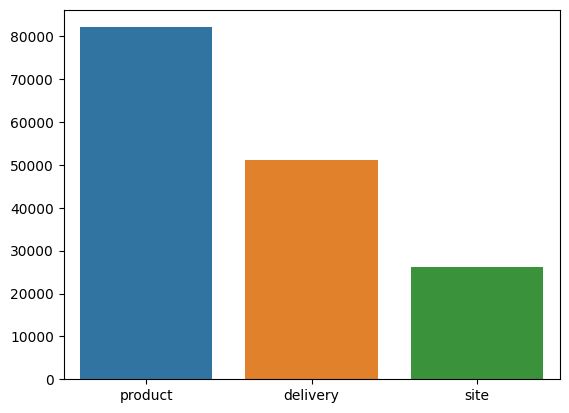

In [ ]:
df_plot = pd.DataFrame(data = {
    'product_review': column_product,
    'delivery_review': column_delivery,
    'site_review': column_site
})

results = {
    'x': ['product', 'delivery', 'site'],
    'y': [np.count_nonzero(column_product), np.count_nonzero(column_delivery), np.count_nonzero(column_site)]
}



sns.barplot(data=results, x="x", y="y")
df_plot = None
results = None
results = None
gc.collect()

3350

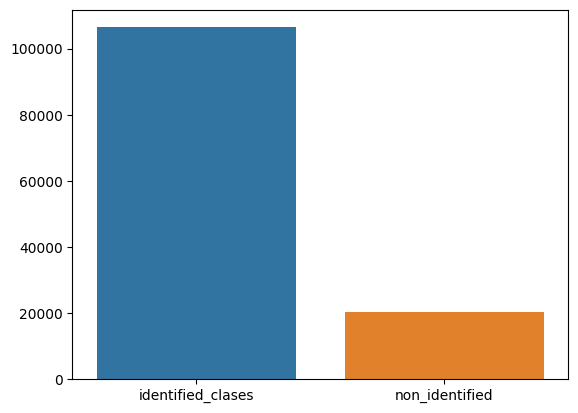

In [ ]:
row_sums = df[['product_review','delivery_review', 'site_review']].sum(axis=1)
count = np.count_nonzero(row_sums == 0)

identified = {
    'x': ['identified_clases', 'non_identified'],
    'y': [len(column_product)-count, count]
}
sns.barplot(data=identified, x="x", y="y")

row_sums = None
identified = None
count = None
gc.collect()

In [ ]:
df_test_treino_e_val = df.query('product_review == 1 | delivery_review == 1 | site_review == 1')
df_test_treino_e_val = df_test_treino_e_val[["review_text", "product_review", "delivery_review", "site_review"]]

df_to_predict = df.query('product_review == 0 & delivery_review == 0 & site_review == 0')
df_to_predict = df_to_predict[["review_text", "product_review", "delivery_review", "site_review"]]

df_test_treino_e_val

,review_text,product_review,delivery_review,site_review
0,bom estou contente com a compra entrega rapida...,False,True,True
1,preco imbativel otima qualidade por apenas r19...,True,False,False
2,atende todas as expectativa supera em agilidad...,True,False,False
4,sem duvidas excelente a entrega foi no prazo a...,True,True,False
5,produto imperdivel excelente produto por fora ...,True,False,False
...,...,...,...,...
126875,otimo produto vale muito estou usando no contr...,True,False,False
126876,sensacional pratico e barato super indico o pr...,False,True,False
126877,otimo produto chegou antes do prazo previsto e...,True,True,False
126878,o produto nao e bom material fraco poderia ser...,True,False,False


In [ ]:
labels = ['product_review', 'delivery_review', 'site_review']

print("lengths", len(df_test_treino_e_val["review_text"]))

len(df_test_treino_e_val.drop('review_text', axis=1).to_numpy())

df_test_treino_e_val = DataFrame({
  "text":   df_test_treino_e_val["review_text"],
  "target":  [x.astype(int) for x in df_test_treino_e_val.drop('review_text', axis=1).to_numpy()]
})


df_to_predict =  DataFrame({
  "text":   df_to_predict["review_text"],
  "target":  [x.astype(int) for x in df_to_predict.drop('review_text', axis=1).to_numpy()]
})

lengths 106467


In [ ]:
train_temp, test = train_test_split(df_test_treino_e_val, test_size=0.3, random_state=42)
train, val = train_test_split(train_temp, test_size=0.25, random_state=42)

column_product = None
column_delivery = None
column_site = None
train_temp = None
df = None

gc.collect()

2822

# 5 - Modelo Bert para categorização

In [ ]:
# BERT Base
model_name = 'neuralmind/bert-base-portuguese-cased'

In [ ]:
# This class was mostly based on a sharing made kindly shared by Gabriel Bianchin de Oliveira. Thanks!
class SequenceClassification():
	def __init__(self,
				model_name,
				num_labels=2,
				multilabel=False,
				learning_rate=1e-5,
				metrics=None,
				tokenizer_model_name=None
				):

		self.model_name = model_name
		self.num_labels = num_labels
		self.multilabel = multilabel
		self.learning_rate = learning_rate

		self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)


		if tokenizer_model_name != None:
			self.tokenizer_model_name = tokenizer_model_name
		else:
			self.tokenizer_model_name = model_name

		self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_model_name, do_lower_case=False)

		if self.num_labels >= 2:
			if self.multilabel:
				self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels, problem_type="multi_label_classification")
				self.model.layers[0].trainable = False
				self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
				if metrics is None:
					self.metrics = ['accuracy']
				else:
					self.metrics = metrics

			else:
				self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels, from_pt=True)
				self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
				if metrics is None:
					self.metrics = ['accuracy']
				else:
					self.metrics = metrics

		else:
			self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels, from_pt=True)
			self.loss = tf.keras.losses.MeanAbsoluteError()
			if metrics is None:
				self.metrics = ['mae']
			else:
				self.metrics = metrics

		self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)


	def tokenize_function(self, sample):
		if self.max_len is None:
			return self.tokenizer(sample["text"])
		else:
			return self.tokenizer(sample["text"], truncation=True, max_length=self.max_len)


	def load_model(self,
			model,
			batch_size=4,
			max_len=None
			):
		self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer, return_tensors="tf")
		self.batch_size = batch_size
		self.epochs = None
		self.max_len = max_len
		self.model = model
		return

	def fit(self,
			df_train,
			df_val=None,
			max_len=None,
			epochs=10,
			batch_size=4,
			model_checkpoint=None,
			early_stopping=None
			):

		self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer, return_tensors="tf")
		self.batch_size = batch_size
		self.epochs = epochs
		self.max_len = max_len

		self.dataset_train = Dataset.from_pandas(df_train, preserve_index=False)
		self.tokenized_dataset_train = self.dataset_train.map(self.tokenize_function)
		self.tf_train_dataset = self.tokenized_dataset_train.to_tf_dataset(
											columns=["attention_mask", "input_ids", "token_type_ids"],
											label_cols=["target"],
											shuffle=True,
											collate_fn=self.data_collator,
											batch_size=self.batch_size)

		if df_val is not None:
			self.dataset_val = Dataset.from_pandas(df_val, preserve_index=False)
			self.tokenized_dataset_val = self.dataset_val.map(self.tokenize_function)
			self.tf_val_dataset = self.tokenized_dataset_train.to_tf_dataset(
											columns=["attention_mask", "input_ids", "token_type_ids"],
											label_cols=["target"],
											shuffle=True,
											collate_fn=self.data_collator,
											batch_size=self.batch_size)

		self.callbacks = []
		# if model_checkpoint is not None:
		# 	if df_val is not None:
		# 		self.callbacks.append(tf.keras.callbacks.ModelCheckpoint(model_checkpoint, save_best_only=True))
		# 	else:
		# 		self.callbacks.append(tf.keras.callbacks.ModelCheckpoint(model_checkpoint, monitor='loss', save_best_only=True))
		# if early_stopping is not None:
		# 	if df_val is not None:
		# 		self.callbacks.append(tf.keras.callbacks.EarlyStopping(patience=early_stopping, restore_best_weights=True))
		# 	else:
		# 		self.callbacks.append(tf.keras.callbacks.EarlyStopping(patience=early_stopping, restore_best_weights=True, monitor='loss'))

		if df_val is not None:
			self.model.fit(self.tf_train_dataset, validation_data=self.tf_val_dataset, epochs=self.epochs, batch_size=self.batch_size)
		else:
			self.model.fit(self.tf_train_dataset, epochs=self.epochs, batch_size=self.batch_size)

	def predict(self,
				df_test
				):

		self.dataset_test = Dataset.from_pandas(df_test, preserve_index=False)
		self.tokenized_dataset_test = self.dataset_test.map(self.tokenize_function)
		self.tf_test_dataset = self.tokenized_dataset_test.to_tf_dataset(
											columns=["attention_mask", "input_ids", "token_type_ids"],
											label_cols=["target"],
											shuffle=False,
											collate_fn=self.data_collator,
											batch_size=self.batch_size)

		self.prediction_logits = self.model.predict(self.tf_test_dataset)['logits']

		if self.num_labels >= 2:
			if self.multilabel:
				return tf.nn.sigmoid(self.prediction_logits).numpy()
			else:
				return tf.nn.softmax(self.prediction_logits).numpy()

		else:
			return self.prediction_logits.numpy()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -av /content/drive/MyDrive/INF-0619/categories/saved_v2_pretrained.h5 ./
skip_fit = True

'/content/drive/MyDrive/INF-0619/categories/saved_v2_pretrained.h5/tf_model.h5' -> './saved_v2_pretrained.h5/tf_model.h5'
'/content/drive/MyDrive/INF-0619/categories/saved_v2_pretrained.h5/config.json' -> './saved_v2_pretrained.h5/config.json'


In [ ]:
model_name = './saved_v2_pretrained.h5'

In [ ]:
seqclf = SequenceClassification(model_name, multilabel=True, num_labels=3, learning_rate=2e-3, metrics=['binary_accuracy', 'categorical_accuracy'], tokenizer_model_name='neuralmind/bert-base-portuguese-cased')

Some layers from the model checkpoint at ./saved_v2_pretrained.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./saved_v2_pretrained.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
if os.path.exists(model_name) and skip_fit:
  seqclf.load_model( TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3), batch_size=16, max_len=256)
else:
  seqclf.fit(df_train=train, df_val=val, epochs=3, batch_size=16, max_len=256)

Some layers from the model checkpoint at ./saved_v2_pretrained.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./saved_v2_pretrained.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
predictions = seqclf.predict(test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/31941 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1997/1997 [==============================] - 286s 142ms/step


In [ ]:
test_predicted_ds = DataFrame({
    'text': test['text'],
    'predictions': [x for x in np.where(predictions > 0.5, 1, 0)],
    'target': test['target']
})

test = None

In [ ]:
def mapfn(sample):
  target = np.array(sample["target"].astype(int))
  pred = np.array(sample["predictions"])

  joined = np.concatenate((target, pred))


  return joined

stats = pd.DataFrame(data=test_predicted_ds[["target", "predictions"]].apply(mapfn, axis=1).to_list(), columns=["target_prod", "target_delivery", "target_site", "pred_prod", "pred_delivery", "pred_site"])
test_predicted_ds = None

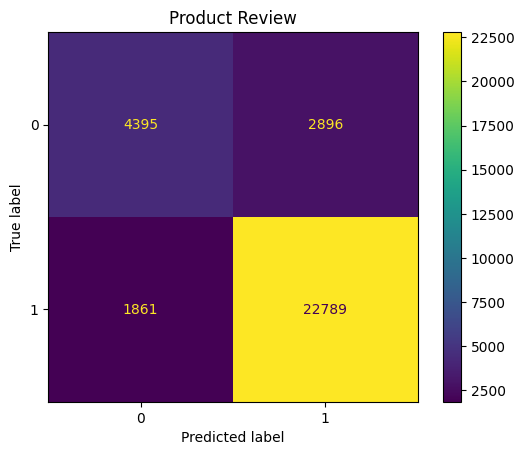

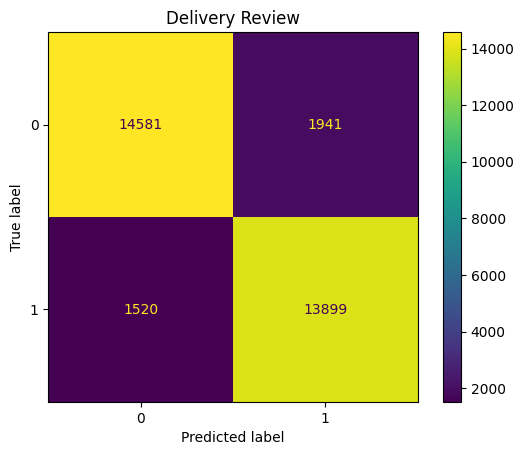

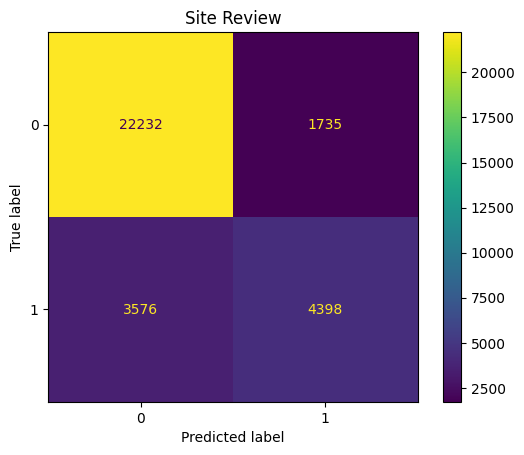

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(stats["target_prod"],stats["pred_prod"])
disp.ax_.set_title("Product Review")


disp = ConfusionMatrixDisplay.from_predictions(stats["target_delivery"],stats["pred_delivery"])
disp.ax_.set_title("Delivery Review")


disp = ConfusionMatrixDisplay.from_predictions(stats["target_site"],stats["pred_site"])
disp.ax_.set_title("Site Review")

disp = None

In [ ]:
print(' --- Accuracy --- ')
print('Product --- ',accuracy_score(stats["target_prod"],stats["pred_prod"]))
print('Delivery --- ',accuracy_score(stats["target_delivery"],stats["pred_delivery"]))
print('Site --- ',accuracy_score(stats["target_site"],stats["pred_site"]))

print(' --- Precision --- ')
print('Product --- ',precision_score(stats["target_prod"],stats["pred_prod"]))
print('Delivery --- ',precision_score(stats["target_delivery"],stats["pred_delivery"]))
print('Site --- ',precision_score(stats["target_site"], stats["pred_site"]))

print(' --- Recall --- ')
print('Product --- ',recall_score(stats["target_prod"],stats["pred_prod"]))
print('Delivery --- ',recall_score(stats["target_delivery"],stats["pred_delivery"]))
print('Site --- ',recall_score(stats["target_site"], stats["pred_site"]))

print(' --- F1 --- ')
print('Product --- ',f1_score(stats["target_prod"],stats["pred_prod"]))
print('Delivery --- ',f1_score(stats["target_delivery"],stats["pred_delivery"]))
print('Site --- ',f1_score(stats["target_site"], stats["pred_site"]))

 --- Accuracy --- 
Product ---  0.8510691587614665
Delivery ---  0.8916439685670455
Site ---  0.833724679878526
 --- Precision --- 
Product ---  0.8872493673350205
Delivery ---  0.8774621212121212
Site ---  0.7171041904451328
 --- Recall --- 
Product ---  0.9245030425963489
Delivery ---  0.9014203255723459
Site ---  0.5515425131677953
 --- F1 --- 
Product ---  0.90549319558955
Delivery ---  0.889279887392431
Site ---  0.6235202381796271
